In [1]:
from datasets import load_dataset
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim


c:\miniforge3\envs\CompBioFinal\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Clinical Only

In [13]:
class ClinicalSurvivalDataset(Dataset):
    def __init__(self, hf_dataset, survival_days=730):
        self.samples = []
        for item in hf_dataset:
            if item["days_to_death"] is not None:
                embedding = np.frombuffer(item["embedding"], dtype=np.float32)
                embedding = embedding.reshape(item["embedding_shape"])
                label = 1 if int(item["days_to_death"]) >= survival_days else 0
                self.samples.append((embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        embedding, label = self.samples[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [15]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
dataset = ClinicalSurvivalDataset(clinical_dataset)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [16]:
sample_input, _ = next(iter(train_loader))
input_dim =  sample_input.view(sample_input.size(0), -1).shape[1] 

model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [17]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        # print(x.shape)
        # print(y.shape)
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).squeeze() > 0.5
            total_correct += (preds == y.bool()).sum().item()
            total += y.size(0)
    return total_correct / total

In [18]:
train_losses = []
val_accuracies = []
for epoch in range(100):
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 - Loss: 0.6693, Val Acc: 0.6103
Epoch 2 - Loss: 0.6666, Val Acc: 0.6103
Epoch 3 - Loss: 0.6621, Val Acc: 0.6103
Epoch 4 - Loss: 0.6560, Val Acc: 0.6103
Epoch 5 - Loss: 0.6603, Val Acc: 0.6103
Epoch 6 - Loss: 0.6519, Val Acc: 0.6103
Epoch 7 - Loss: 0.6541, Val Acc: 0.6117
Epoch 8 - Loss: 0.6449, Val Acc: 0.6103
Epoch 9 - Loss: 0.6591, Val Acc: 0.6200
Epoch 10 - Loss: 0.6530, Val Acc: 0.6103
Epoch 11 - Loss: 0.6494, Val Acc: 0.6103
Epoch 12 - Loss: 0.6501, Val Acc: 0.6158
Epoch 13 - Loss: 0.6475, Val Acc: 0.6089
Epoch 14 - Loss: 0.6423, Val Acc: 0.6227
Epoch 15 - Loss: 0.6408, Val Acc: 0.6186
Epoch 16 - Loss: 0.6383, Val Acc: 0.6186
Epoch 17 - Loss: 0.6354, Val Acc: 0.6200
Epoch 18 - Loss: 0.6416, Val Acc: 0.6130
Epoch 19 - Loss: 0.6352, Val Acc: 0.6200
Epoch 20 - Loss: 0.6317, Val Acc: 0.6089
Epoch 21 - Loss: 0.6274, Val Acc: 0.5936
Epoch 22 - Loss: 0.6360, Val Acc: 0.6144
Epoch 23 - Loss: 0.6195, Val Acc: 0.6214
Epoch 24 - Loss: 0.6247, Val Acc: 0.5520
Epoch 25 - Loss: 0.6363, 

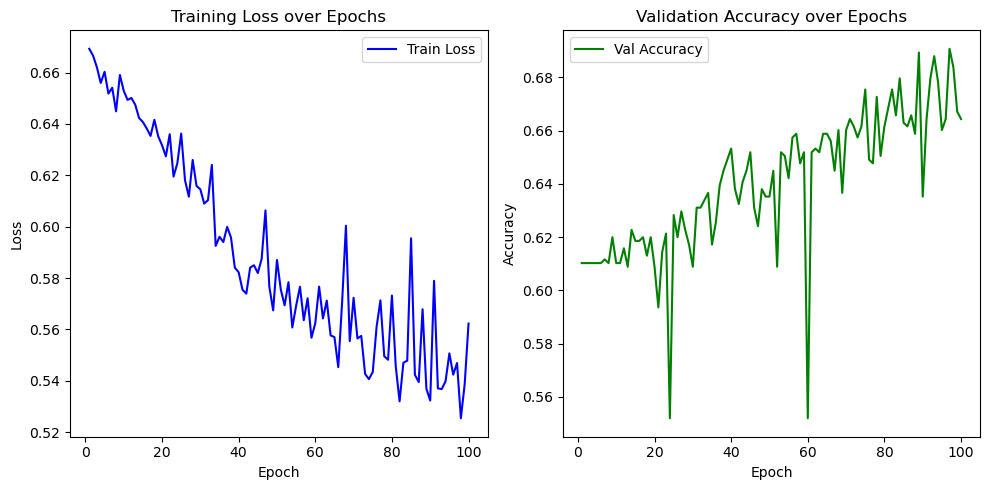

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, 101)  # 100 epochs

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


MULTIMODAL

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

In [40]:
class MultiModalModel(nn.Module):
    def __init__(self, input_dims, num_stages, num_diagnosis, hidden_dim=64, embedding_dim=32):
        super(MultiModalModel, self).__init__()

        self.clinical_mlp = MLP(input_dims['clinical'], hidden_dim, embedding_dim)
        self.molecular_mlp = MLP(input_dims['molecular'], hidden_dim, embedding_dim)
        self.pathology_mlp = MLP(input_dims['pathology'], hidden_dim, embedding_dim)

        concat_dim = embedding_dim * 3

        self.stage_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_stages)
        )

        self.diagnosis_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_diagnosis)
        )

    def forward(self, clinical_x, molecular_x, pathology_x):
        clinical_embed = self.clinical_mlp(clinical_x)
        molecular_embed = self.molecular_mlp(molecular_x)
        pathology_embed = self.pathology_mlp(pathology_x)

        combined = torch.cat([clinical_embed, molecular_embed, pathology_embed], dim=1)
        class_output = self.classifier(combined)
        survival_output = self.survival_head(combined)

        return class_output, survival_output

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch

class MultiModalSurvivalDataset(Dataset):
    def __init__(self, dataset_df, survival_days=730):
        self.samples = []
        
        for row in dataset_df.itertuples():
            state = getattr(row, 'ajcc_pathologic_stage')
            diagnosis = getattr(row, 'primary_diagnosis')
            if state is not None and diagnosis is not None:
                # Clinical Data Processing
                clinical_embedding = np.frombuffer(getattr(row, 'embedding_clin'), dtype=np.float32)
                clinical_embedding = clinical_embedding.reshape(getattr(row, 'embedding_shape_clin')).squeeze()
                
                # Molecular Data Processing
                molecular_embedding = getattr(row, 'embedding_mol').squeeze()
                
                # Pathology Data Processing
                pathology_embedding = np.frombuffer(getattr(row, 'embedding_path'), dtype=np.float32)
                pathology_embedding = pathology_embedding.reshape(getattr(row, 'embedding_shape_path')).squeeze()
                
                # Label for diagnosis
                label = 1 if int(days_to_death) >= survival_days else 0
                
                # Add the combined data and label to the sample list
                self.samples.append((clinical_embedding, molecular_embedding, pathology_embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        clinical_embedding, molecular_embedding, pathology_embedding, label = self.samples[idx]
        return (torch.tensor(clinical_embedding, dtype=torch.float32), 
                torch.tensor(molecular_embedding, dtype=torch.float32), 
                torch.tensor(pathology_embedding, dtype=torch.float32), 
                torch.tensor(label, dtype=torch.float32))


In [8]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
pathology_report_dataset = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")
molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")

### Data Merging

In [33]:
clinical_dataset

Dataset({
    features: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number', 'age_at_index', 'days_to_birth', 'days_to_death', 'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth', 'year_of_death', 'age_at_diagnosis', 'ajcc_clinical_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'classification_of_tumor', 'days_to_diagnosis', 'icd_10_code', 'last_known_disease_status', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'progression_or_recurrence', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis', 'treatment_or_therapy', 'alcohol_history', 'is_ffpe', 'composition', 'days_to_collection', 'days_to_sample_procurement', 'initial_weight', 'pathology_report_uuid', 'portion_submitter_id', 'percent_lymphocyte_infiltrat

In [39]:
list(set(clinical_dataset['tissue_or_organ_of_origin']))

['Lower lobe, lung',
 'Fundus of stomach',
 'Lung, NOS',
 'Upper third of esophagus',
 'Small intestine, NOS',
 'Gastric antrum',
 'Medulla of adrenal gland',
 'Parietal lobe',
 'Pylorus',
 'Skin, NOS',
 'Overlapping lesion of eye and adnexa',
 'Endometrium',
 'Nervous system, NOS',
 'Connective, subcutaneous and other soft tissues of lower limb and hip',
 'Short bones of lower limb and associated joints',
 'Lower-outer quadrant of breast',
 'Spermatic cord',
 'Trigone of bladder',
 'Thymus',
 'Unknown primary site',
 'Connective, subcutaneous and other soft tissues, NOS',
 'Ciliary body',
 'Gum, NOS',
 'Lymph nodes of head, face and neck',
 'Stomach, NOS',
 'Myometrium',
 'Transverse colon',
 'Testis, NOS',
 'Adrenal gland, NOS',
 'Hypopharynx, NOS',
 'Peripheral nerves and autonomic nervous system of upper limb and shoulder',
 'Splenic flexure of colon',
 'Overlapping lesion of connective, subcutaneous and other soft tissues',
 'Brain, NOS',
 'Brain stem',
 'Lesser curvature of stoma

In [55]:
clinical_dataset['case_submitter_id']

['TCGA-OR-A5J1',
 'TCGA-OR-A5J2',
 'TCGA-OR-A5J3',
 'TCGA-OR-A5J4',
 'TCGA-OR-A5J5',
 'TCGA-OR-A5J6',
 'TCGA-OR-A5J7',
 'TCGA-OR-A5J8',
 'TCGA-OR-A5J9',
 'TCGA-OR-A5JA',
 'TCGA-OR-A5JB',
 'TCGA-OR-A5JC',
 'TCGA-OR-A5JD',
 'TCGA-OR-A5JE',
 'TCGA-OR-A5JF',
 'TCGA-OR-A5JG',
 'TCGA-OR-A5JH',
 'TCGA-OR-A5JI',
 'TCGA-OR-A5JJ',
 'TCGA-OR-A5JK',
 'TCGA-OR-A5JL',
 'TCGA-OR-A5JM',
 'TCGA-OR-A5JO',
 'TCGA-OR-A5JP',
 'TCGA-OR-A5JQ',
 'TCGA-OR-A5JR',
 'TCGA-OR-A5JS',
 'TCGA-OR-A5JT',
 'TCGA-OR-A5JU',
 'TCGA-OR-A5JV',
 'TCGA-OR-A5JW',
 'TCGA-OR-A5JX',
 'TCGA-OR-A5JY',
 'TCGA-OR-A5JZ',
 'TCGA-OR-A5K0',
 'TCGA-OR-A5K1',
 'TCGA-OR-A5K2',
 'TCGA-OR-A5K3',
 'TCGA-OR-A5K4',
 'TCGA-OR-A5K5',
 'TCGA-OR-A5K6',
 'TCGA-OR-A5K8',
 'TCGA-OR-A5K9',
 'TCGA-OR-A5KB',
 'TCGA-OR-A5KO',
 'TCGA-OR-A5KP',
 'TCGA-OR-A5KQ',
 'TCGA-OR-A5KS',
 'TCGA-OR-A5KT',
 'TCGA-OR-A5KU',
 'TCGA-OR-A5KV',
 'TCGA-OR-A5KW',
 'TCGA-OR-A5KX',
 'TCGA-OR-A5KY',
 'TCGA-OR-A5KZ',
 'TCGA-OR-A5L1',
 'TCGA-OR-A5L2',
 'TCGA-OR-A5L3',
 'TCGA-OR-A5L4

In [9]:
# Examine how many times each patient ID shows up
clin_counts = defaultdict(int)
for id in clinical_dataset['case_submitter_id']:
    clin_counts[id] += 1
print(clin_counts)
print(f'There are {len(clin_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(clin_counts.values())))

# Print the ones that show multiple times
clin_anomalies = dict()
for id, count in clin_counts.items():
    if count != 1:
        clin_anomalies[id] = count
print(clin_anomalies)
print(f'{len(clin_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-OR-A5J1': 1, 'TCGA-OR-A5J2': 1, 'TCGA-OR-A5J3': 1, 'TCGA-OR-A5J4': 1, 'TCGA-OR-A5J5': 1, 'TCGA-OR-A5J6': 1, 'TCGA-OR-A5J7': 1, 'TCGA-OR-A5J8': 1, 'TCGA-OR-A5J9': 1, 'TCGA-OR-A5JA': 1, 'TCGA-OR-A5JB': 1, 'TCGA-OR-A5JC': 1, 'TCGA-OR-A5JD': 1, 'TCGA-OR-A5JE': 1, 'TCGA-OR-A5JF': 1, 'TCGA-OR-A5JG': 1, 'TCGA-OR-A5JH': 1, 'TCGA-OR-A5JI': 1, 'TCGA-OR-A5JJ': 1, 'TCGA-OR-A5JK': 1, 'TCGA-OR-A5JL': 1, 'TCGA-OR-A5JM': 1, 'TCGA-OR-A5JO': 1, 'TCGA-OR-A5JP': 1, 'TCGA-OR-A5JQ': 1, 'TCGA-OR-A5JR': 1, 'TCGA-OR-A5JS': 1, 'TCGA-OR-A5JT': 1, 'TCGA-OR-A5JU': 1, 'TCGA-OR-A5JV': 1, 'TCGA-OR-A5JW': 1, 'TCGA-OR-A5JX': 1, 'TCGA-OR-A5JY': 1, 'TCGA-OR-A5JZ': 1, 'TCGA-OR-A5K0': 1, 'TCGA-OR-A5K1': 1, 'TCGA-OR-A5K2': 1, 'TCGA-OR-A5K3': 1, 'TCGA-OR-A5K4': 1, 'TCGA-OR-A5K5': 1, 'TCGA-OR-A5K6': 1, 'TCGA-OR-A5K8': 1, 'TCGA-OR-A5K9': 1, 'TCGA-OR-A5KB': 1, 'TCGA-OR-A5KO': 1, 'TCGA-OR-A5KP': 1, 'TCGA-OR-A5KQ': 1, 'TCGA-OR-A5KS': 1, 'TCGA-OR-A5KT': 1, 'TCGA-OR-A5KU': 1, 'TCGA-OR-A5KV': 1, 'TC

In [26]:
pathology_report_dataset

Dataset({
    features: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type', 'file_size', 'created_datetime', 'PatientID', 'gdc_case_id', 'report_text', 'embedding', 'embedding_shape'],
    num_rows: 11208
})

In [60]:
pathology_report_dataset['PatientID']

['TCGA-P6-A5OG',
 'TCGA-OR-A5J7',
 'TCGA-OR-A5KS',
 'TCGA-OR-A5LL',
 'TCGA-OR-A5KB',
 'TCGA-OR-A5JP',
 'TCGA-OR-A5J8',
 'TCGA-OR-A5JL',
 'TCGA-OR-A5K8',
 'TCGA-OR-A5LO',
 'TCGA-OR-A5K6',
 'TCGA-OR-A5KV',
 'TCGA-OR-A5JD',
 'TCGA-OR-A5JQ',
 'TCGA-OR-A5L5',
 'TCGA-OR-A5LT',
 'TCGA-OR-A5KX',
 'TCGA-OR-A5JV',
 'TCGA-OR-A5L1',
 'TCGA-OR-A5JY',
 'TCGA-OR-A5KU',
 'TCGA-OR-A5JX',
 'TCGA-PK-A5H8',
 'TCGA-OR-A5JA',
 'TCGA-OR-A5JH',
 'TCGA-OR-A5JO',
 'TCGA-OR-A5LN',
 'TCGA-PK-A5HA',
 'TCGA-OR-A5J4',
 'TCGA-OR-A5L8',
 'TCGA-OR-A5KY',
 'TCGA-OR-A5JW',
 'TCGA-OR-A5KP',
 'TCGA-OR-A5KW',
 'TCGA-OR-A5K2',
 'TCGA-OR-A5JG',
 'TCGA-OR-A5J5',
 'TCGA-OR-A5K4',
 'TCGA-OR-A5LR',
 'TCGA-OR-A5LF',
 'TCGA-OR-A5JS',
 'TCGA-PK-A5H9',
 'TCGA-P6-A5OF',
 'TCGA-PA-A5YG',
 'TCGA-PK-A5HC',
 'TCGA-OR-A5L4',
 'TCGA-OR-A5J2',
 'TCGA-P6-A5OH',
 'TCGA-OR-A5JZ',
 'TCGA-OR-A5KZ',
 'TCGA-PK-A5HB',
 'TCGA-OR-A5LK',
 'TCGA-OR-A5JR',
 'TCGA-OR-A5JJ',
 'TCGA-OR-A5KQ',
 'TCGA-OR-A5L2',
 'TCGA-OR-A5JK',
 'TCGA-OR-A5J9',
 'TCGA-OR-A5J1

In [10]:
# Examine how many times each patient ID shows up
path_counts = defaultdict(int)
for id in pathology_report_dataset['PatientID']:
    path_counts[id] += 1
print(path_counts)
print(f'There are {len(path_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(path_counts.values())))

# Print the ones that show multiple times
path_anomalies = dict()
for id, count in path_counts.items():
    if count != 1:
        path_anomalies[id] = count
print(path_anomalies)
print(f'{len(path_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-P6-A5OG': 1, 'TCGA-OR-A5J7': 1, 'TCGA-OR-A5KS': 1, 'TCGA-OR-A5LL': 1, 'TCGA-OR-A5KB': 1, 'TCGA-OR-A5JP': 1, 'TCGA-OR-A5J8': 1, 'TCGA-OR-A5JL': 1, 'TCGA-OR-A5K8': 1, 'TCGA-OR-A5LO': 1, 'TCGA-OR-A5K6': 1, 'TCGA-OR-A5KV': 1, 'TCGA-OR-A5JD': 1, 'TCGA-OR-A5JQ': 1, 'TCGA-OR-A5L5': 1, 'TCGA-OR-A5LT': 1, 'TCGA-OR-A5KX': 1, 'TCGA-OR-A5JV': 1, 'TCGA-OR-A5L1': 1, 'TCGA-OR-A5JY': 1, 'TCGA-OR-A5KU': 1, 'TCGA-OR-A5JX': 1, 'TCGA-PK-A5H8': 1, 'TCGA-OR-A5JA': 1, 'TCGA-OR-A5JH': 1, 'TCGA-OR-A5JO': 1, 'TCGA-OR-A5LN': 1, 'TCGA-PK-A5HA': 1, 'TCGA-OR-A5J4': 1, 'TCGA-OR-A5L8': 1, 'TCGA-OR-A5KY': 1, 'TCGA-OR-A5JW': 1, 'TCGA-OR-A5KP': 1, 'TCGA-OR-A5KW': 1, 'TCGA-OR-A5K2': 1, 'TCGA-OR-A5JG': 1, 'TCGA-OR-A5J5': 1, 'TCGA-OR-A5K4': 1, 'TCGA-OR-A5LR': 1, 'TCGA-OR-A5LF': 1, 'TCGA-OR-A5JS': 1, 'TCGA-PK-A5H9': 1, 'TCGA-P6-A5OF': 1, 'TCGA-PA-A5YG': 1, 'TCGA-PK-A5HC': 1, 'TCGA-OR-A5L4': 1, 'TCGA-OR-A5J2': 1, 'TCGA-P6-A5OH': 1, 'TCGA-OR-A5JZ': 1, 'TCGA-OR-A5KZ': 1, 'TCGA-PK-A5HB': 1, 'TC

In [27]:
molecular_dataset

Dataset({
    features: ['PatientID', 'SampleID', 'Embeddings'],
    num_rows: 13804
})

In [29]:
molecular_dataset['PatientID']

['TCGA-02-0001',
 'TCGA-02-0009',
 'TCGA-02-0021',
 'TCGA-02-0024',
 'TCGA-02-0026',
 'TCGA-02-0028',
 'TCGA-02-0033',
 'TCGA-02-0038',
 'TCGA-02-0043',
 'TCGA-02-0046',
 'TCGA-02-0051',
 'TCGA-02-0060',
 'TCGA-02-0064',
 'TCGA-02-0069',
 'TCGA-02-0070',
 'TCGA-02-0071',
 'TCGA-02-0075',
 'TCGA-02-0079',
 'TCGA-02-0080',
 'TCGA-02-0084',
 'TCGA-02-0086',
 'TCGA-02-0089',
 'TCGA-02-0102',
 'TCGA-02-0107',
 'TCGA-02-0111',
 'TCGA-02-0113',
 'TCGA-02-0114',
 'TCGA-02-0116',
 'TCGA-02-0285',
 'TCGA-02-0290',
 'TCGA-02-0317',
 'TCGA-02-0321',
 'TCGA-02-0326',
 'TCGA-02-0337',
 'TCGA-02-0339',
 'TCGA-02-0432',
 'TCGA-02-0440',
 'TCGA-02-0451',
 'TCGA-02-2486',
 'TCGA-04-1335',
 'TCGA-04-1336',
 'TCGA-04-1337',
 'TCGA-04-1337',
 'TCGA-04-1341',
 'TCGA-04-1342',
 'TCGA-04-1342',
 'TCGA-04-1346',
 'TCGA-04-1346',
 'TCGA-04-1348',
 'TCGA-04-1348',
 'TCGA-04-1349',
 'TCGA-04-1350',
 'TCGA-04-1350',
 'TCGA-04-1353',
 'TCGA-04-1353',
 'TCGA-04-1356',
 'TCGA-04-1356',
 'TCGA-04-1361',
 'TCGA-04-1362

In [11]:
# Examine how many times each patient ID shows up
mol_counts = defaultdict(int)
for id in molecular_dataset['PatientID']:
    mol_counts[id] += 1
print(mol_counts)
print(f'There are {len(mol_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(mol_counts.values())))

# Print the ones that show multiple times
mol_anomalies = dict()
for id, count in mol_counts.items():
    if count != 1:
        mol_anomalies[id] = count
print(mol_anomalies)
print(f'{len(mol_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-02-0001': 1, 'TCGA-02-0009': 1, 'TCGA-02-0021': 1, 'TCGA-02-0024': 1, 'TCGA-02-0026': 1, 'TCGA-02-0028': 1, 'TCGA-02-0033': 1, 'TCGA-02-0038': 1, 'TCGA-02-0043': 1, 'TCGA-02-0046': 1, 'TCGA-02-0051': 1, 'TCGA-02-0060': 1, 'TCGA-02-0064': 1, 'TCGA-02-0069': 1, 'TCGA-02-0070': 1, 'TCGA-02-0071': 1, 'TCGA-02-0075': 1, 'TCGA-02-0079': 1, 'TCGA-02-0080': 1, 'TCGA-02-0084': 1, 'TCGA-02-0086': 1, 'TCGA-02-0089': 1, 'TCGA-02-0102': 1, 'TCGA-02-0107': 1, 'TCGA-02-0111': 1, 'TCGA-02-0113': 1, 'TCGA-02-0114': 1, 'TCGA-02-0116': 1, 'TCGA-02-0285': 1, 'TCGA-02-0290': 1, 'TCGA-02-0317': 1, 'TCGA-02-0321': 1, 'TCGA-02-0326': 1, 'TCGA-02-0337': 1, 'TCGA-02-0339': 1, 'TCGA-02-0432': 1, 'TCGA-02-0440': 1, 'TCGA-02-0451': 1, 'TCGA-02-2486': 1, 'TCGA-04-1335': 2, 'TCGA-04-1336': 2, 'TCGA-04-1337': 2, 'TCGA-04-1341': 1, 'TCGA-04-1342': 2, 'TCGA-04-1346': 2, 'TCGA-04-1348': 2, 'TCGA-04-1349': 2, 'TCGA-04-1350': 2, 'TCGA-04-1353': 2, 'TCGA-04-1356': 2, 'TCGA-04-1361': 2, 'TC

In [ ]:
# Clearly most of these only show up once, even if the sample letter makes it seem as if there may be more
sorted(molecular_dataset['SampleID'])

['TCGA-02-0001-01C',
 'TCGA-02-0003-01A',
 'TCGA-02-0004-01A',
 'TCGA-02-0006-01B',
 'TCGA-02-0007-01A',
 'TCGA-02-0009-01A',
 'TCGA-02-0010-01A',
 'TCGA-02-0011-01B',
 'TCGA-02-0014-01A',
 'TCGA-02-0015-01A',
 'TCGA-02-0016-01A',
 'TCGA-02-0021-01A',
 'TCGA-02-0023-01B',
 'TCGA-02-0024-01B',
 'TCGA-02-0025-01A',
 'TCGA-02-0026-01B',
 'TCGA-02-0027-01A',
 'TCGA-02-0028-01A',
 'TCGA-02-0033-01A',
 'TCGA-02-0034-01A',
 'TCGA-02-0037-01A',
 'TCGA-02-0038-01A',
 'TCGA-02-0039-01A',
 'TCGA-02-0043-01A',
 'TCGA-02-0046-01A',
 'TCGA-02-0047-01A',
 'TCGA-02-0048-01A',
 'TCGA-02-0051-01A',
 'TCGA-02-0052-01A',
 'TCGA-02-0054-01A',
 'TCGA-02-0055-01A',
 'TCGA-02-0057-01A',
 'TCGA-02-0058-01A',
 'TCGA-02-0059-01A',
 'TCGA-02-0060-01A',
 'TCGA-02-0064-01A',
 'TCGA-02-0068-01A',
 'TCGA-02-0069-01A',
 'TCGA-02-0070-01A',
 'TCGA-02-0071-01A',
 'TCGA-02-0074-01A',
 'TCGA-02-0075-01A',
 'TCGA-02-0079-01A',
 'TCGA-02-0080-01A',
 'TCGA-02-0083-01A',
 'TCGA-02-0084-01A',
 'TCGA-02-0085-01A',
 'TCGA-02-008

In [12]:
# Compute the final intersection of IDs to form our dataset. We want to exclude anomalies from each set and then
# find the intersection

clin_set = set(list(clin_counts.keys())) - set(list(clin_anomalies.keys()))
path_set = set(list(path_counts.keys())) - set(list(path_anomalies.keys()))
mol_set = set(list(mol_counts.keys())) - set(list(mol_anomalies.keys()))

final_ids = mol_set.intersection(path_set, clin_set)
print(len(final_ids))

8413


In [78]:
print(set(pathology_report_dataset.column_names).intersection(set(clinical_dataset.column_names)))
print(set(pathology_report_dataset.column_names).intersection(set(molecular_dataset.column_names)))
print(set(clinical_dataset.column_names).intersection(set(molecular_dataset.column_names)))

{'state', 'embedding', 'embedding_shape'}
{'PatientID'}
set()


In [13]:
# Now we want to remove all the ids not in final_ids from each of the datasets
# also rename colliding columns so things are clear after joining
clinical_filtered = clinical_dataset.filter(
    lambda x: x['case_submitter_id'] in final_ids
).rename_columns({'embedding': 'embedding_clin', 'embedding_shape': 'embedding_shape_clin', 'state': 'state_clin'}).to_pandas()
pathology_filtered = pathology_report_dataset.filter(
    lambda x: x['PatientID'] in final_ids
).rename_columns({'embedding': 'embedding_path', 'embedding_shape': 'embedding_shape_path', 'state': 'state_path'}).to_pandas()
molecular_filtered = molecular_dataset.filter(
    lambda x: x['PatientID'] in final_ids,
).rename_column('Embeddings', 'embedding_mol').to_pandas()

In [14]:
# Join on the PatientID
intermediate_merge = pathology_filtered.merge(clinical_filtered, how='inner', left_on='PatientID', right_on='case_submitter_id')
merged_dataset = intermediate_merge.merge(molecular_filtered, how='inner', on='PatientID')

### Run Multitask Model

In [19]:
merged_dataset['embedding_shape_clin']

0       [1, 1, 1024]
1       [1, 1, 1024]
2       [1, 1, 1024]
3       [1, 1, 1024]
4       [1, 1, 1024]
            ...     
8408    [1, 1, 1024]
8409    [1, 1, 1024]
8410    [1, 1, 1024]
8411    [1, 1, 1024]
8412    [1, 1, 1024]
Name: embedding_shape_clin, Length: 8413, dtype: object

In [23]:
multidataset = MultiModalSurvivalDataset(merged_dataset)

In [26]:
# 2. Get input dimensions
sample = multidataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2].shape)
clinical_dim = sample[0].shape[0]
molecular_dim = sample[1].shape[0]
pathology_dim = sample[2].shape[0]

input_dims = {
    'clinical': clinical_dim,
    'molecular': molecular_dim,
    'pathology': pathology_dim
}

# 3. Initialize model, dataloader, loss functions, optimizer
model = MultiModalModel(input_dims).cuda()  # or .to(device) if you're managing device explicitly

torch.Size([1024])
torch.Size([48])
torch.Size([1024])


In [32]:
# Split into train and val
train_size = int(0.8 * len(multidataset))
val_size = len(multidataset) - train_size
train_dataset_multi, val_dataset_multi = random_split(multidataset, [train_size, val_size])

train_loader_multi = DataLoader(train_dataset_multi, batch_size=64, shuffle=True)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=64)

print(next(iter(train_loader_multi))[0].shape)
print(next(iter(train_loader_multi))[1].shape)
print(next(iter(train_loader_multi))[2].shape)
print(next(iter(train_loader_multi))[3].shape)

torch.Size([64, 1024])
torch.Size([64, 48])
torch.Size([64, 1024])
torch.Size([64])


In [ ]:
criterion_classification = nn.CrossEntropyLoss()
criterion_survival = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:

# 4. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss, total_cls_loss, total_surv_loss = 0, 0, 0
    
    for batch in dataloader:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, labels = batch
        clinical_x = clinical_x.cuda()
        molecular_x = molecular_x.cuda()
        pathology_x = pathology_x.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()
        class_output, survival_output = model(clinical_x, molecular_x, pathology_x)
        
        loss_cls = criterion_classification(class_output, labels)
        loss_surv = criterion_survival(survival_output.squeeze(), survival_days)
        loss = loss_cls + loss_surv

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += loss_cls.item()
        total_surv_loss += loss_surv.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Classification Loss: {total_cls_loss:.4f} | Survival Loss: {total_surv_loss:.4f}")


RuntimeError: Tensors must have same number of dimensions: got 4 and 2